# EDA

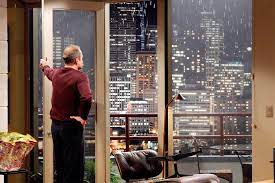

## Stakeholder and her Aims

Our customer calls herself Amy Williams. She's originally from Sicily and speaks with a thick Italian accent but made her requirements very clear:

She owns several central houses that she describes accurately as being in the top 10%. She wants to sell these houses over the course of the next years. The revenue she wants to invest in property that gives her more privacy and makes her stand out less, because she despises flamboyancy. And nosey neighbours. 

We assume that she wants to be able to get as many hideaways as possible for her money.

A basement would be a plus for gambling with good friends and storing concrete-encased objects.

### Research Questions

1. When is a good time to sell central high-profile real estate?
2. Which houses on the outskirt are as average as possible?

### Hypotheses and Guidelines for the House Hunt

1. House prices are higher in spring than during the rest of the year, with a peak in march.
2. The further away from the city centre, the lower the cost per sqft.
3. The further away from the city centre, the larger the basement.
4. Condition strongly correlates with price per sqft.


Guideline: Suitable houses are comparable to the neighbourhood in terms of size and lot.

## Preparation

To set up the notebook, let's first import the necessary libraries and load the data we want to explore


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#I have no idea what the following does, so I commented it out but left it in here because you never know.
#import warnings

#warnings.filterwarnings("ignore")

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df_houses = pd.read_csv('data/King_County_House_prices_dataset.csv', parse_dates=True)

## Overview of the Dataset

Now let's have a first look at the dataset and explore it's properties.

In [ ]:
df_houses.head()

In [ ]:
df_houses.info()

Here, we already got some interesting information.
Regarding missings, we see that there are a load of missings in the "waterfront" (2376, or 11%) and "yr_renovated" (3842, 17%) column that need to be dealt with. Few missings also can be found in the "view" column (63, 0.3%).
How we deal with these will also depend on our RQs, so we'll deal with those later.

"date" is type object, so is "sqft_basement". Investigate:

In [ ]:
type(df_houses['date'][0])

It's a string! Convert it to a date:

In [ ]:
# change "date" dtype to datetime coming from the format %m/%d/%Y
df_houses['date'] = pd.to_datetime(df_houses['date'], format='%m/%d/%Y')

Check again:

In [ ]:
type(df_houses['date'][0])

Ok, cool. Moving on to the sqft_basement. This should be a float or an integer, so why is it not?

In [ ]:
#Check all values for non-integers
df_houses.sqft_basement.unique()

Aha! The culprit is a question mark. Let's replace it with a missing value and convert it to a float:

In [ ]:
df_houses['sqft_basement'] = df_houses.sqft_basement.replace('?',np.NaN)

df_houses = df_houses.astype({'sqft_basement': float})

Check whether that worked:

In [ ]:
df_houses.head(10)

Excellent. Time for one more overview: Where are those houses? Let's make a nice geographical map.

In [ ]:
fig = px.scatter_mapbox(df_houses, lat="lat", lon="long", hover_name="id", hover_data=["zipcode","price","grade"],
                        color_discrete_sequence=["purple"], zoom=8, height=800, opacity=0.8)
fig.update_layout(mapbox_style="open-street-map") # specify map type. You can go more artsy with stamen-watercolor, for example.
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0}) # sets the margin from the left, top, right and bottom order
fig.update_layout(title_text='Houses in King County', title_x=0.5) # sets a title for the plot and centers it
fig.show()

These are quite a lot of sales. Are there any duplicates?

In [ ]:
df_houses[df_houses.duplicated()]

Nope!

All right. Time to take a bit of a deeper dive into the house prices. Let's look at how they are distributed.

In [ ]:
print(df_houses.price.describe())
print(df_houses.price.mode())
sns.histplot(df_houses['price'])
plt.ticklabel_format(style='plain', axis='both')
plt.show()

In [ ]:
sns.boxplot(df_houses['price'])
q1=df_houses['price'].quantile(0.25)
q3=df_houses['price'].quantile(0.75)
iqr = q3-q1

llim_price = q1 - iqr*1.5
ulim_price = q3 + iqr*1.5

print(llim_price)
print(ulim_price)

Looks slightly positively skewed, with outliers being houses costing more than 1129500 $.

Let's see what there is to know about the price per sqft.

In [ ]:
df_houses['price_sqft']=(df_houses['price']/df_houses['sqft_living'])

In [ ]:
sns.boxplot(data=df_houses['price_sqft'], orient='h')

...and let's investigate the most expensive ones.

In [ ]:
df_houses.query('price_sqft > 790')

Generally speaking, these outliers look like real data. Most expensive houses are large, and houses with an extremely high price per sqft are in good condition and central, but still close to waterfronts or natural reserves.

Now we still need to deal with the missings previously identified. Let's see where the waterfront-missings are located on the map:

In [ ]:
fig = px.scatter_mapbox(df_houses[df_houses['waterfront'].isnull()], lat="lat", lon="long", hover_name="id", hover_data=["zipcode","price","grade"],
                        color_discrete_sequence=["blue"], zoom=8, height=800, opacity=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.update_layout(title_text='Houses in King County', title_x=0.5)
fig.show()

While most missings are non-waterfront houses, this is not true for all. We thus will keep the missings as missings, and not include the variable to calculate metrics we need.

In [ ]:
fig = px.scatter_mapbox(df_houses[df_houses['view'].isna()], lat="lat", lon="long", hover_name="id", hover_data=["zipcode","price","grade"],
                        color_discrete_sequence=["blue"], zoom=8, height=800, opacity=0.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.update_layout(title_text='Houses in King County', title_x=0.5)
fig.show()

This seems to be equally true for "View" - however, this is difficult to assess. Since there are few missings in this column, the respective rows can just be omitted when running relevant analyses.

Moving on to the missings in the renovation column, let's check how they compare to non-renovated houses in terms of sales price.

In [ ]:
#replace missings with 100, so they are easier to compare in a graph.
df_houses['yr_renovated'] = df_houses['yr_renovated'].fillna(100)
chart=sns.barplot(data=df_houses.query('yr_renovated < 1950'), y=df_houses.query('yr_renovated < 1990')['price'], x=df_houses.query('yr_renovated < 1950')['yr_renovated'])

House prices for houses with missing renovation dates are virtually the same as those with no renovation date. It therefore seems fair to replace them with zeroes, associating them with unrenovated houses.

In [ ]:
df_houses['yr_renovated'] = df_houses['yr_renovated'].replace(100,0)

Ok, now we got a good overview over our dataset. It's time to move on to the research questions to make our client happy.

# Answering our Research Questions
## When should our client sell?

As you might remember, our customer is a maf... law-obiding citizen who owns several central houses in the top 10% of the market that she wants to get rid of.
Instead, she looks to purchase a variety of average houses on the outskirts to have some privacy and no contact with law enforcement (she has a specific phobia that makes her feel uncomfortable around FBI agents).

Thus, we need to identify what's the best time to sell expensive city houses, and what houses in the outskirts are so eye-wateringly boring that nobody would bother to look there.

Let's start by finding the most expensive central houses (which I define as being in the city of Seattle).

In [ ]:
#List of Seattle zipcodes
seattle = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98110, 98111, 98112, 98113, 98114, 98115, 98116, 98117, 98118, 98119, 98121, 98122, 98124, 98125, 98126, 98127, 98129, 98131, 98133, 98134, 98136, 98138, 98139, 98141, 98144, 98145, 98146, 98148, 98154, 98155, 98158, 98160, 98161, 98164, 98165, 98166, 98168, 98170, 98174, 98175, 98177, 98178, 98181, 98185, 98188, 98190, 98191, 98194, 98195, 98198, 98199]

...and the distance to the city centre for each house:

In [ ]:
#calculate distance from seattle city centre
seattle_centre_lat = 47.606
seattle_centre_lon = -122.332

df_houses['dist_centre'] = np.sqrt((df_houses['lat']-seattle_centre_lat)**2 + (df_houses['long']-seattle_centre_lon)**2)

To find out what's the best month to sell, we also need to be able to identify months in the first place, so we need to extract them from the date column as well.

In [ ]:
df_houses['month']=df_houses['date'].dt.month

Now create a new dataset including only the houses in Seattle City.

In [ ]:
df_seattle = df_houses.loc[df_houses['zipcode'].isin(seattle)]

df_seattle.nunique()

But here's a question:
### What makes a top 10% house?

Let us pick some columns and enter them in a stepwise regression model and see how that performs in predicting house prices.

In [ ]:
import statsmodels.api as sm

y = df_seattle['price']
x_columns = ['sqft_living', 'condition', 'grade', 'yr_built', 'sqft_living15', 'dist_centre']

def get_stats():
    x = df_seattle[x_columns]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

From the regression weights, we can calculate a score for each house that predicts how likely it is to achieve a good price.

In [ ]:
df_seattle['rating']=(df_seattle['sqft_living']*148+df_seattle['condition']*46260+df_seattle['grade']*108500+(df_seattle['yr_built']*(-390))+df_seattle['sqft_living15']*153+df_seattle['dist_centre']*(-1914000))

df_seattle.describe()

Now let us see how the months differ from each other in terms of sales prices for the top 10 houses in Seattle:

In [ ]:
df_t10r = df_seattle.loc[df_seattle['rating']>=df_seattle.rating.quantile(0.9)]

print(df_t10r['price'].describe())
print(df_t10r.groupby('month')['price'].median())

df_t10r['d_price'] = df_t10r['price']-df_t10r['price'].median()
colors = ['g' if d >= 0 else 'r' for d in df_t10r['d_price']]

#and for those who hate boxplots:
sns.barplot(data=df_t10r, x='month', y='d_price', estimator=np.median, ci=None, color='purple')#, palette='colors')
plt.ylabel('Deviation from median Price (in 1,000 $)')
plt.xlabel('Month of Sale')
plt.yticks(range(-100000, 109000,25000),[-100, -75, -50, -25, 0, +25, +50, +75, +100])
plt.xticks(range(0,12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.axhline(0, color='black', lw=1)
plt.show()

There is no huge difference between the months in terms of sales price. Most sales take place in June, least in January. The highest median price for the top 10 % buildings can be achieved in March (1,155,000$), the lowest in August (971,000$).

### Finding new property on the outskirts ###

So now that we know when to sell (all the time), it's time to look at the properties we want to buy. First, we want to identify properties on the outskirts, which we will do by calculating their distance from the city centre.



We predicted a correlation between price and distance from city centre. Let's see whether that holds true:

In [ ]:
np.corrcoef(df_houses['dist_centre'], df_houses['price_sqft'])

df_houses['price_sqft'].describe()

A correlation coefficient of _r_ = .47 indicates a moderate to strong negative correlation between distance from city centre and price per sqft. That means, the further out a house, the cheaper it tends to be per square foot.
This can also nicely be seen on the following map, where darker dots indicate lower prices:

In [ ]:
fig = px.scatter_mapbox(df_houses, lat="lat", lon="long", color='price_sqft', labels={'price_sqft': '$ / sqft'}, hover_name="id", hover_data=["zipcode","price","grade"],
                        color_discrete_sequence=["blue"], zoom=8, height=800)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.update_layout(title_text='Houses in King County', title_x=0.5)
fig.show()

Also, our customer is interested in houses with a rather large basement. We predict that those can also be found on the outskirts:

In [ ]:
#as correlations apparently can't handle missings, we assume that the missing basement information means that there is no basement, so we replace the NaN with a zero.
np.nan_to_num(df_houses['sqft_basement'], copy=False, nan=0.0)

df_houses['sqft_basement'].head(20)

In [ ]:
np.corrcoef(df_houses['dist_centre'], df_houses['sqft_basement'])

In [ ]:
sns.scatterplot(data=df_houses, x='dist_centre', y='sqft_basement', color='purple')
plt.ylabel('Size of Basement (in sqft)')
plt.xlabel('Distance to City Centre')
plt.xticks([0, 0.5, 1],['close', 'medium', 'far out'])
plt.show()

This does not seem to be the case. Possibly, houses in the city centre have basements, whereas houses in the outskirts have larger lots, making basements unnecessary.

In [ ]:
np.corrcoef(df_houses['dist_centre'], df_houses['sqft_lot'])

In [ ]:
np.corrcoef(df_houses['sqft_lot'], df_houses['sqft_basement'])

could be.

As a last hypothesis, we predicted that the building's condition strongly correlates with price per sqft.

In [ ]:
np.corrcoef(df_houses['condition'], df_houses['price_sqft'])

df_houses.condition.corr(df_houses.price_sqft, method='spearman')

We see that there is a correlation, but with _r_ = .10, it's rather weak. Why is that the case?

Looking more closely at the "Condition" variable, we see that it only has five values, and only very few houses in a terrible state: 

In [ ]:
df_houses['condition'].value_counts()

In [ ]:
sns.barplot(data=df_houses, x='condition', y='price_sqft', color='purple')
plt.ylabel('Price per sqft')
plt.xlabel('Condition')
plt.xticks([0,1,2,3,4],['rats avoid it', 'some mold', 'standard', 'good as new', 'polished af'])
plt.show()

Various plots can show what exactly that means, but it's most apparent in a scatterplot: Only very few houses in bad condition are sold, and they vary in price a lot. This suggests that houses in such bad condition are either torn down, and only sold when they are really special or standing on very expensive ground.

To wrap this section up, let's get an overview over how all the houses' properties relate to each other:

In [ ]:
df_corr = df_houses[['price','sqft_living','sqft_lot','condition','grade','sqft_basement','sqft_living15','sqft_lot15','price_sqft','dist_centre']]

sns.heatmap(df_corr.corr(method='spearman'), annot=True, linewidths=.01, fmt='.2f', center=0, cmap='coolwarm')

## Find average houses

We further wanted to identify houses that are really similar to their neighbourhood, so we can recommend very non-outstanding houses to our client.

In [ ]:
#calculate the difference between each real estate's size and its neighbourhood's average

df_houses['d_living_sqft'] = (df_houses['sqft_living'] - df_houses['sqft_living15'])
df_houses['d_lot_sqft'] = df_houses['sqft_lot'] - df_houses['sqft_lot15']

livingplot = sns.histplot(data=df_houses, x='d_living_sqft')

In [ ]:
# plot the same graph but without outliers to make it more comprehensible

def reject_outliers(data, m = 1.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

livingplot = sns.histplot(data=df_houses, x=reject_outliers(df_houses['d_living_sqft'],3))

In [ ]:
lotplot = sns.histplot(data=df_houses, x=reject_outliers(df_houses['d_lot_sqft'],3))

In [ ]:
fig = px.scatter_mapbox(df_houses, lat="lat", lon="long", color=np.sqrt(abs(df_houses['d_living_sqft'])), hover_name="d_living_sqft", hover_data=["price","grade"],
                        color_discrete_sequence=["blue"], zoom=8, height=500)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.update_layout(title_text='Houses in King County', title_x=0.5)
fig.show()

However, none of these measures give us a definite answer on which houses we could recommend to our client. Thus, let's draw up the
## M.A.F.I.A. - Metric for the Assessment of Fit of Assets

Everything you want in one score!

- Distance to centre
- Similarity to neighbours
- Size of basement

To do that, we first need to bring all these indicators to the same scale - standardised to range from 0 to 1.

In [ ]:
df_houses['d_living_sqft_abs']=abs(df_houses['d_living_sqft'])
df_houses['d_lot_sqft_abs']=abs(df_houses['d_lot_sqft'])

c = ['sqft_basement', 'dist_centre','d_living_sqft_abs','d_lot_sqft_abs']
s = '_z'
cs = ''
for i in c:
       cs=i+s
       df_houses[cs] = (df_houses[i] - df_houses[i].min()) / (df_houses[i] - df_houses[i].min()).max()

From these variables, we can now calculate the m.a.f.i.a. (which we then standardise as well, to make it more comprehensible).

In [ ]:
#calculate m.a.f.i.a.
df_houses['mafia']=(df_houses['sqft_basement_z']+df_houses['dist_centre_z']+(1-df_houses['d_living_sqft_abs_z'])+(1-df_houses['d_lot_sqft_abs_z'])/4)

#standardize
df_houses['mafia'] =( df_houses['mafia']-df_houses['mafia'].mean()) / df_houses['mafia'].std()
df_houses['mafia'] = (df_houses['mafia'] - df_houses['mafia'].min()) / (df_houses['mafia'] - df_houses['mafia'].min()).max()

In [ ]:
sns.histplot(data=df_houses, x='mafia')
plt.show()
df_houses.mafia.describe()

So which are the top 10 m.a.f.i.a.-houses?

In [ ]:
df_houses.query('mafia > 0.449').sort_values(by='mafia', ascending=False).head(10)[['id','date','price','sqft_living','sqft_living15','sqft_lot','sqft_lot15','condition','grade','sqft_basement','yr_built','dist_centre_z','mafia']]

There are some real bargains here! They are in reasonable condition, two of them have huge basements (while the rest is at least far out in the countryside), and they don't stand out from the neighbourhood. What more do you want when hiding from the FBI?

Now let's have a look at where we can find them on the map, and then drive by there:

In [ ]:
df_houses.query('mafia > 0.449').sort_values(by='mafia', ascending=False).head(10)

fig = px.scatter_mapbox(df_houses.query('mafia > 0.449').sort_values(by='mafia', ascending=False).head(10), lat="lat", lon="long", color='mafia', hover_name="id", hover_data=["price","grade"],
                        color_discrete_sequence=["purple"], zoom=8, height=800, labels={'mafia':'M.A.Fi.A.'})
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.update_layout(title_text='Houses in King County', title_x=0.5)
fig.show()